<a href="https://colab.research.google.com/github/aslesani/pgmpy_fork/blob/master/src/default_test/deep_models_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file is old. the new one is saved in 
https://github.com/aslesani/pgmpy_fork.git
with name deep_modes_colab


---



In [0]:
!git clone https://github.com/aslesani/pgmpy_fork.git
#ls
#!git clone https://github.com/aslesani/created_dataset2.git
#!rm -r pgmpy_fork  


Cloning into 'pgmpy_fork'...
remote: Enumerating objects: 303, done.
remote: Counting objects: 100% (303/303), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 1308 (delta 158), reused 265 (delta 122), pack-reused 1005
Receiving objects: 100% (1308/1308), 704.16 KiB | 6.90 MiB/s, done.
Resolving deltas: 100% (717/717), done.


In [0]:
cd pgmpy_fork/src/default_test

/content/pgmpy_fork/src/default_test


In [0]:
'''Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
# Notes
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
import numpy as np

from read_write import data_preparation_for_sequences_based_deep_models, convert_binary_classes_to_zero_and_one

from sklearn.metrics import f1_score, precision_score , recall_score, accuracy_score


Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt

def plot_train_val_graph(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  print('epochs:' , epochs)
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

  
def get_max_len_of_sequences(list_of_sequences):
  lengths = [len(list_of_sequences[i]) for i in range(len(list_of_sequences))]
  return max(lengths) , min(lengths) , lengths


def get_set_of_sensor_events(list_of_sequences):
 
  set_of_sensor_events = set()
  
  for i in range(len(list_of_sequences)):
      set_of_sensor_events = set_of_sensor_events.union(set(list_of_sequences[i]))
  
  return set_of_sensor_events, len(set_of_sensor_events)


#!pip install tabulate 

from tabulate import tabulate

#print(tabulate([['Alice', 24], ['Bob', 19]], headers=['algorithm', 'acc']))

def print_list_of_lists(data , headers):
    print(tabulate(data, headers=headers))

def test_print_list_of_lists():
    data = [['Alice', 24], ['Bob', 19]]
    headers=['algorithm', 'acc']
    print_list_of_lists(data , headers)


In [0]:
from keras import backend as K

def mcor(y_true, y_pred):
    #matthews_correlation
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
 
 
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
 
 
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
 
 
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
 
 
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
 
 
    return numerator / (denominator + K.epsilon())


def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    #print("y_true:", y_true)
    #print("y_pred:",y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    #print("precision:", precision)
    #print("recall:", recall)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_skl(y_true, y_pred):
    f1_score_micro = f1_score(y_true, y_pred, average='micro') 
    return f1_score_micro



In [0]:
#! cd pgmpy_fork/src/default_test
#!ls
#!git clone https://github.com/pgmpy/pgmpy 
#cd ..
#!ls
#!cd pgmpy/
#pip install -r requirements.txt
#!python setup.py install


In [0]:
def create_model_and_apply_on_data(x_train, y_train,x_test, y_test, max_features,
                                   embedding_vector_dim = 8, batch_size = 32, epochs = 10, 
                                   loss = 'binary_crossentropy', optimizer='rmsprop', metrics=[f1], 
                                   plot_trainvalgraph = True,
                                   number_of_lstm_layers = 1,
                                   ID_of_layer_to_repeat = 0):
  '''
  Parameters:
  ===============
  number_of_lstm_layers (default value = 1)
      indicate the number of layers in stack of layers
  
  ID_of_layer_to_repeat (default value = 0)
     0: LSTM
     1:RNN
     2: GRU
  
  '''
  #batch_size = 32

  print('Build model...')
  model = Sequential()
  model.add(Embedding(max_features+1, embedding_vector_dim))
  #model.add(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
  #model.add(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
  
  layer_names = [LSTM, SimpleRNN, GRU]
  if number_of_lstm_layers > 1:
        for l in range(number_of_lstm_layers-1):
            model.add(layer_names[ID_of_layer_to_repeat](64, dropout=0.2, recurrent_dropout=0.2, return_sequences = True))
  model.add(layer_names[ID_of_layer_to_repeat](64, dropout=0.2, recurrent_dropout=0.2))
        
  model.add(Dense(1, activation='sigmoid'))

  model.summary()

  # try using different optimizers and different optimizer configs
  model.compile(loss= loss,
                optimizer=optimizer,
                metrics= metrics)#, mcor,recall, f1])

  print('Train...')
  history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test))
  score, acc = model.evaluate(x_test, y_test,
                              batch_size=batch_size)
  #print('Test score:', score)# i think score is loss value
  #print('Test accuracy:', acc)
 
  #print(model.layers[0].output)
  if plot_trainvalgraph:
      plot_train_val_graph(history)
      
  return score, acc, history, len(x_train), len(x_test)

In [0]:
def return_number_of_words_of_dataset(dataset_name):
    if dataset_name == "Twor2009": 
        number_of_words = 122
    elif dataset_name == "Tulum2009":
        number_of_words = 32
    elif dataset_name == "Tulum2010":
        number_of_words = 62
    else:
        number_of_words = int(input("Enter number_of_words: Twor2009:122 Tulum2009: 32 Tulum2010: 62\nfor"+ address_to_read + "\n"))
    
    return number_of_words

def return_embedding_vector_dim(dataset_name):
    if dataset_name == "Twor2009": 
        embedding_vector_dim = 64
    else:
        embedding_vector_dim = 8

    return embedding_vector_dim

def return_metric(dataset_name):
   if dataset_name == "Twor2009": 
        metric = [f1]
   else:
        metric = ['accuracy']
    
   return metric

In [0]:
def select_hyperparameters(address_to_read, ID_of_layer_to_repeat, hasActivitycol, dataset_name ,metrics, shuffle):
    #address_to_read= r"E:/pgmpy/Seq of sensor events_based on activities/based_on_activities.csv"
    #address_to_read = r"E:\pgmpy\Seq of sensor events_no overlap_based on different deltas\delta_{}min.csv"
    #address_to_read = r"E:\pgmpy\Seq of sensor events_based_on_activity_and_no_overlap_delta\delta_{}min.csv"
    
    number_of_words = return_number_of_words_of_dataset(dataset_name)
    embedding_vector_dim = return_embedding_vector_dim(dataset_name)

    for layers in range(1,5):
        print("number_of_lstm_layers:" , layers)

        results = []
        for delta in [75]:#[15,45,60,75,90,100, 120,150, 180,200,240,300,400,500,600,700,800,900,1000]: #list(range(1,15)) + [15, 30,45,60,75,90,100, 120,150, 180,200,240,300,400,500,600,700,800,900,1000]: 
            print("delta:" , delta)
            x_train, x_test, y_train, y_test, max_features, maxlen = data_preparation_for_sequences_based_deep_models(address_to_read = address_to_read.format(dt = dataset_name,d = delta),
                                                                                                                  number_of_words = number_of_words, 
                                                                                                                  max_seq_len = 20,
                                                                                                                  hasActivitycol= hasActivitycol,
                                                                                                                  shuffle = shuffle)
            
            
            #122 for twor2009, tulum2009 32, tulum2010 62
           
            test_score, test_acc, history, num_of_train_samples, num_of_test_sample = create_model_and_apply_on_data(x_train =x_train, 
                                                                                                y_train = y_train,
                                                                                                x_test = x_test, 
                                                                                                y_test = y_test, 
                                                                                                max_features = max_features,
                                                                                                number_of_lstm_layers = layers,
                                                                                                ID_of_layer_to_repeat = ID_of_layer_to_repeat,
                                                                                                metrics = metrics,
                                                                                                embedding_vector_dim = embedding_vector_dim)
            results.append([delta, 
                        num_of_train_samples, 
                        num_of_test_sample, 
                        history.history['loss'][-1], 
                        history.history['f1'][-1] ,
                        test_score, 
                        test_acc])#, history.history
        #print(history.history)
        print_list_of_lists(results, ['delta(min)' ,
                                  '#train', 
                                  '#test', 
                                  'train loss(last)', 
                                  'train_f1(last)', 
                                  'val loss ', 
                                  'val f1', ])#'history'
        print("results=", results)
        #print("results[:][-1]:", results[:][-1])
        #best_val_acc_index = np.argmax(results[:][-1])
        #print("****************************************")
        #print("best vlidation acc delta:" , results[best_val_acc_index][0])
    
    return results
    
    

In [0]:
!git clone https://github.com/aslesani/created_dataset2.git


fatal: destination path 'created_dataset2' already exists and is not an empty directory.


created_dataset2/{dt}/Seq of sensor events_based_on_activity_and_no_overlap_delta/delta_{d}min.csv
Twor2009
ID_of_layer_to_repeat: 1
number_of_lstm_layers: 1
delta: 75
$$$$$$$$before shuffle
$$$$$$$after shuffle
Pad sequences (samples x time)
x_train shape: (2976, 20)
x_test shape: (743, 20)
Build model...
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 64)          7872      
_________________________________________________________________
simple_rnn_28 (SimpleRNN)    (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 16,193
Trainable params: 16,193
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 2976 samples, validate on 743 samples
Epoch 1/10
2976

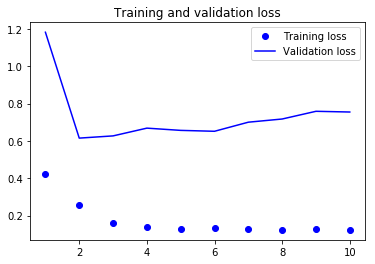

  delta(min)    #train    #test    train loss(last)    train_f1(last)    val loss     val f1
------------  --------  -------  ------------------  ----------------  -----------  --------
          75      2976      743            0.123685          0.808683     0.754794  0.855174
results= [[75, 2976, 743, 0.12368479766632601, 0.8086825134933636, 0.7547941834240911, 0.8551743726871537]]
number_of_lstm_layers: 2
delta: 75
$$$$$$$$before shuffle
$$$$$$$after shuffle
Pad sequences (samples x time)
x_train shape: (2976, 20)
x_test shape: (743, 20)
Build model...
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 64)          7872      
_________________________________________________________________
simple_rnn_29 (SimpleRNN)    (None, None, 64)          8256      
_________________________________________________________________
simple_rnn_30 (Simp

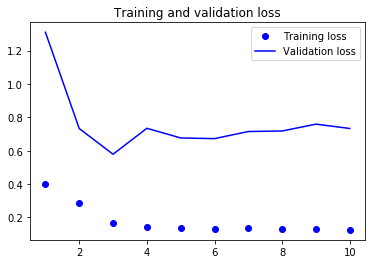

  delta(min)    #train    #test    train loss(last)    train_f1(last)    val loss     val f1
------------  --------  -------  ------------------  ----------------  -----------  --------
          75      2976      743            0.124839          0.830655     0.733261  0.852498
results= [[75, 2976, 743, 0.12483921493854254, 0.8306551537206096, 0.7332614574325679, 0.8524979068966605]]
number_of_lstm_layers: 3
delta: 75
$$$$$$$$before shuffle
$$$$$$$after shuffle
Pad sequences (samples x time)
x_train shape: (2976, 20)
x_test shape: (743, 20)
Build model...
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 64)          7872      
_________________________________________________________________
simple_rnn_31 (SimpleRNN)    (None, None, 64)          8256      
_________________________________________________________________
simple_rnn_32 (Simp

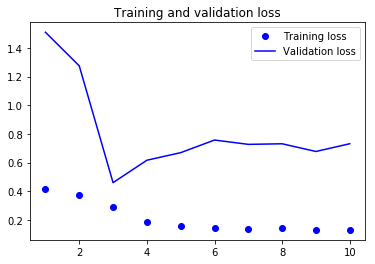

  delta(min)    #train    #test    train loss(last)    train_f1(last)    val loss     val f1
------------  --------  -------  ------------------  ----------------  -----------  --------
          75      2976      743            0.131596          0.821049     0.731609  0.849627
results= [[75, 2976, 743, 0.13159554297485018, 0.8210490893933081, 0.7316089750118403, 0.849627182910452]]
number_of_lstm_layers: 4
delta: 75
$$$$$$$$before shuffle
$$$$$$$after shuffle
Pad sequences (samples x time)
x_train shape: (2976, 20)
x_test shape: (743, 20)
Build model...
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 64)          7872      
_________________________________________________________________
simple_rnn_34 (SimpleRNN)    (None, None, 64)          8256      
_________________________________________________________________
simple_rnn_35 (Simpl

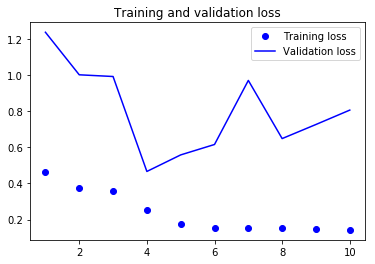

  delta(min)    #train    #test    train loss(last)    train_f1(last)    val loss     val f1
------------  --------  -------  ------------------  ----------------  -----------  --------
          75      2976      743            0.142536           0.82307     0.806405  0.832208
results= [[75, 2976, 743, 0.14253622353557618, 0.823070321031796, 0.8064049097457412, 0.8322084704125714]]


In [0]:
dataset_name = "Twor2009"
shuffle = False
#address_to_read, hasActivitycol= r"created_dataset2/{dt}/Seq of sensor events_based on activities/based_on_activities.csv", True
#address_to_read, hasActivitycol = r"created_dataset2/{dt}/Seq of sensor events_no overlap_based on different deltas/delta_{d}min.csv", False
address_to_read, hasActivitycol = r"created_dataset2/{dt}/Seq of sensor events_based_on_activity_and_no_overlap_delta/delta_{d}min.csv", True
#address_to_read = address_to_read.format(d, dataset_name)
print(address_to_read)
print(dataset_name)
ID_of_layer_to_repeat = 1
print("ID_of_layer_to_repeat:" , ID_of_layer_to_repeat)
metrics = return_metric(dataset_name)

results = select_hyperparameters(address_to_read = address_to_read , 
                                 ID_of_layer_to_repeat = ID_of_layer_to_repeat, 
                                 hasActivitycol = hasActivitycol,
                                 dataset_name = dataset_name,
                                 metrics = metrics,
                                shuffle = shuffle)

In [0]:
print(results[:][-1])
print(np.argmax(results[:][-1]))

In [0]:
dataset_name = "Tulum2010"
shuffle = True

address_to_read= r"created_dataset2/{}/Seq of sensor events_based on activities/based_on_activities.csv".format(dataset_name)

number_of_words = return_number_of_words_of_dataset(dataset_name)


x_train, x_test, y_train, y_test, max_features, maxlen = data_preparation_for_sequences_based_deep_models(address_to_read,
                                                                                                         number_of_words = number_of_words, 
                                                                                                        max_seq_len = 20,
                                                                                                         hasActivitycol = True,
                                                                                                         shuffle = shuffle)
ID_of_layer_to_repeat = 0
embedding_vector_dim = return_embedding_vector_dim(dataset_name)

metric = return_metric(dataset_name)
for layers in range(1,5):
    print("number_of_layers:" , layers)

    test_score, test_f1, history, num_of_train_samples, num_of_test_sample = create_model_and_apply_on_data(x_train, 
                                                                                                        y_train,
                                                                                                        x_test, 
                                                                                                        y_test, 
                                                                                                        max_features,
                                                                                                        number_of_lstm_layers = layers,
                                                                                                        ID_of_layer_to_repeat = ID_of_layer_to_repeat,
                                                                                                        embedding_vector_dim = embedding_vector_dim,
                                                                                                        metrics = metric)
    print("test_score:",test_score)
    print("test_f1:" , test_f1)
    print("history:" , history.history)
    print("num_of_train_samples:" , num_of_train_samples)
    print("num_of_test_sample:" , num_of_test_sample)


$$$$$$$$before shuffle
> /content/pgmpy_fork/src/default_test/shuffle_data.py(8)unison_shuffled_copies()
-> changed_type = False
(Pdb) type(a)
<class 'list'>
(Pdb) type(b)
<class 'list'>
(Pdb) len(a)
343012
(Pdb) len(b)
343012
(Pdb) n
> /content/pgmpy_fork/src/default_test/shuffle_data.py(9)unison_shuffled_copies()
-> if type(a) == list:
(Pdb) n
> /content/pgmpy_fork/src/default_test/shuffle_data.py(10)unison_shuffled_copies()
-> changed_type = True
(Pdb) n
> /content/pgmpy_fork/src/default_test/shuffle_data.py(11)unison_shuffled_copies()
-> a = np.array(a)
(Pdb) type(a)
<class 'list'>
(Pdb) n


In [0]:
x_train, x_test, y_train, y_test, max_features, maxlen = imdb_lstm_data_preparation(maxlen=10)
#my_x_train, my_x_test, my_y_train, my_y_test, my_max_features, my_maxlen = data_preparation_for_sequences_based_deep_models(address_to_read)
#x_train, x_test, y_train, y_test, max_features, maxlen = data_preparation_for_sequences_based_deep_models(address_to_read)#imdb_lstm_data_preparation(maxlen=10)
create_model_and_apply_on_data(x_train, y_train,x_test, y_test, max_features,embedding_vector_dim = maxlen)

In [0]:
embeddings = model.layers[0].get_weights()[0]
print(embeddings)

In [0]:
# `word_to_index` is a mapping (i.e. dict) from words to their index, e.g. `love`: 69
words_embeddings = {w:embeddings[idx] for w, idx in word_to_index.items()}

# now you can use it like this for example
print(words_embeddings['love'])  # possible output: [0.21, 0.56, ..., 0.65, 0.10]


In [0]:
print(type(score) , type(acc))

In [0]:
def imdb_lstm_data_preparation(max_features = 20000, maxlen = 80):
  #max_features = 20000#number_of_events
  # cut texts after this number of words (among top max_features most common words)
  #maxlen = 10#max_seq_len

  print('Loading data...')
  (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
  print(len(x_train), 'train sequences')
  print(len(x_test), 'test sequences')

  #print('before apply pad_sequence, x_train[0]:' , x_train[0])

  print('Pad sequences (samples x time)')
  x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
  x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
  print('x_train shape:', x_train.shape)
  print('x_test shape:', x_test.shape)
  
  return x_train, x_test, y_train, y_test, max_features, maxlen



def make_lstm_without_embedding(x_train, y_train,x_test, y_test, max_features,embedding_vector_dim = 64, batch_size = 32, epochs = 5, 
                                   loss = 'binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'], plot_train_val_graph = False):
  
  #batch_size = 32

  print('Build model...')
  model = Sequential()
  #model.add(Embedding(max_features+1, embedding_vector_dim))
  #model.add(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
  #model.add(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
  model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(1, activation='sigmoid'))

  model.summary()

  # try using different optimizers and different optimizer configs
  model.compile(loss= loss,
                optimizer=optimizer,
                metrics= metrics)#, mcor,recall, f1])

  print('Train...')
  history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test))
  score, acc = model.evaluate(x_test, y_test,
                              batch_size=batch_size)
  print('Test score:', score)# i think score is loss value
  print('Test accuracy:', acc)
 
  if plot_train_val_graph:
      plot_train_val_graph(history)
      
  return score, acc, history, len(x_train), len(x_test)